# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# Import and download nltk package
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
# Import libraries
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, fbeta_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
df = pd.read_sql('SELECT * FROM InsertTableName', con=engine)
df.head()
X = df['message']
Y = df[df.columns[4:]]


### 2. Write a tokenization function to process your text data

In [4]:
# Create function that tokenizes text input
def tokenize(text):
    '''
    Function splitting messages into words, converting to lower case and removing punctuation
    Args: text = message in form of string
    Return: clean_tokens = list of cleaned tokens
    '''
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    return clean_tokens   
       

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# Create pipeline that uses CountVectorizer, a TfidfTransformer and then classifies the message via RandomForstClassier
# The predictor is supplemented by the MultiOutputClassifier to ensure that multiple target variables are predicted
pipeline_rf_not_opt = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('randomf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10)))
])


### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y)


In [7]:
# Training the machine learning pipeline
pipeline_rf_not_opt.fit(X_train, y_train)

y_pred_rf_not_opt = pipeline_rf_not_opt.predict(X_test)


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [8]:
# Create function to store performance metrics
def performance_metrics(y_pred):
    '''
    Function to compare the performance metrics of different ML pipelines
    Args: y_pred = list of predicted labels
    Returns: dictionary with precision, recall and f1_score for each target category
    '''
    # Convert y_pred from array to dataframe
    y_pred = pd.DataFrame(y_pred, columns=df.columns[4:])
    
    # Create dictionary where keys are the target categories and values is a list of the performance metrics
    score_dict = defaultdict()
    for col in y_pred.columns:
        precision = precision_score(y_test[col], y_pred[col])
        recall = recall_score(y_test[col], y_pred[col])
        f1_score = fbeta_score(y_test[col], y_pred[col], beta=1)
        score_dict[col] = [float(precision), float(recall), float(f1_score)]
        
    return score_dict
    

In [9]:
# Get the performance metrics of random forest classifier whose parameters have not been tuned
random_forest_not_opt = performance_metrics(y_pred_rf_not_opt)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### 6. Improve your model
Use grid search to find better parameters. 

In [10]:
# Get list of all parameters that can be used for GridSearchCV
pipeline_rf_not_opt.get_params().keys()


dict_keys(['memory', 'steps', 'vect', 'tfidf', 'randomf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'randomf__estimator__bootstrap', 'randomf__estimator__class_weight', 'randomf__estimator__criterion', 'randomf__estimator__max_depth', 'randomf__estimator__max_features', 'randomf__estimator__max_leaf_nodes', 'randomf__estimator__min_impurity_decrease', 'randomf__estimator__min_impurity_split', 'randomf__estimator__min_samples_leaf', 'randomf__estimator__min_samples_split', 'randomf__estimator__min_weight_fraction_leaf', 'randomf__estimator__n_estimators', 'randomf__estimator__n_jobs', 'randomf__estimator__oob_score', 'randomf__estima

In [11]:
# Define parameters to be used for grid search
parameters = {
    'vect__max_df': [0.5, 0.7, 0.9, 1],
    'tfidf__use_idf': [True, False],
    'randomf__estimator__n_estimators': [5, 20, 30],
    'randomf__estimator__max_depth': [5, 7, 9, 11],
}

# Instantiate GridSearchCV
cv = GridSearchCV(pipeline_rf_not_opt, param_grid=parameters, cv=3)

# Fit the grid search model and return the predictions for the optimal parameter combination
cv.fit(X_train, y_train)
y_pred_rf_opt = cv.predict(X_test)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [12]:
# Get the performance metrics of random forest classifier whose parameters have been tuned
random_forest_opt =  performance_metrics(y_pred_rf_opt)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [13]:
# Create alternative pipeline with different machine learning algorithm
pipeline_adaboost = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('adaboost', MultiOutputClassifier(AdaBoostClassifier()))
])

# Training the machine learning pipeline
pipeline_adaboost.fit(X_train, y_train)

y_pred_ada = pipeline_adaboost.predict(X_test)


In [14]:
# Iterate through columns of y_pred and y_test and calculate precision, recall and f1_score for Adaboost classifier
adaboost =  performance_metrics(y_pred_ada)
   

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
# Create alternative pipeline with onehot encoding
pipeline_binary = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, binary=True)),
    ('tfidf', TfidfTransformer()),
    ('adaboost', MultiOutputClassifier(AdaBoostClassifier()))
])

# Training the machine learning pipeline
pipeline_binary.fit(X_train, y_train)

y_pred_binary = pipeline_binary.predict(X_test)

# Iterate through columns of y_pred and y_test and calculate precision, recall and f1_score for onehot encoding
binary =  performance_metrics(y_pred_binary)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


defaultdict(None,
            {'related': [0.8723404255319149,
              0.791792395896198,
              0.8301170515659602],
             'request': [0.8, 0.7125140924464487, 0.7537268932617771],
             'offer': [0.0, 0.0, 0.0],
             'aid_related': [0.8302808302808303,
              0.6960081883316275,
              0.7572383073496659],
             'medical_help': [0.6197183098591549,
              0.3188405797101449,
              0.4210526315789473],
             'medical_products': [0.6190476190476191,
              0.33766233766233766,
              0.4369747899159664],
             'search_and_rescue': [0.25,
              0.05172413793103448,
              0.08571428571428572],
             'security': [0.16666666666666666,
              0.045454545454545456,
              0.07142857142857144],
             'military': [1.0, 0.09090909090909091, 0.16666666666666669],
             'child_alone': [0.0, 0.0, 0.0],
             'water': [0.8324022346368715,
     

In [19]:
list_all_pred = [adaboost, random_forest_not_opt, random_forest_opt, binary]
list_all_pred_names = ['AdaBoost', 'Random Forest not optimized', 'Random Forest optimized', 'Binarization']


In [32]:
# Create a function that will take a list of the performance scores of all models as an input
# and returns a combined dataframe
def transform_predictions(list_all_pred, names):
    '''
    Function to transform the prediction outputs of each model and combine them in one dataframe
    Args: list_all_pred = list with all prediction dictionaries
          names = list of model names
    Returns: df_melt = dataframe of all performance scores
    '''
    
    # Names of the scores
    score = ['precision', 'recall', 'f1_score']
    
    # Convert arrays into dataframes
    df_all_models = pd.DataFrame()
    for i in range(len(list_all_pred)):
        df_temp = pd.DataFrame(list_all_pred[i])
        df_temp['score'] = score
        df_temp['model'] = names[i]
        df_all_models = df_all_models.append(df_temp)

    # Melt the dataframe to get a structure that will allow plotting the results in a barchart
    df_melt = pd.melt(df_all_models, id_vars=['model', 'score'], var_name='cat_type', value_name='value')

    return df_melt


In [33]:
# Create the melted dataframe that will serve as an input to the plotting function below
df_melt = transform_predictions(list_all_pred, list_all_pred_names)
df_melt


,model,score,cat_type,value
0,AdaBoost,precision,related,0.856494
1,AdaBoost,recall,related,0.796017
2,AdaBoost,f1_score,related,0.825149
3,Random Forest not optimized,precision,related,0.813650
4,Random Forest not optimized,recall,related,0.827399
5,Random Forest not optimized,f1_score,related,0.820467
6,Random Forest optimized,precision,related,0.669823
7,Random Forest optimized,recall,related,0.981895
8,Random Forest optimized,f1_score,related,0.796378
9,Binarization,precision,related,0.872340


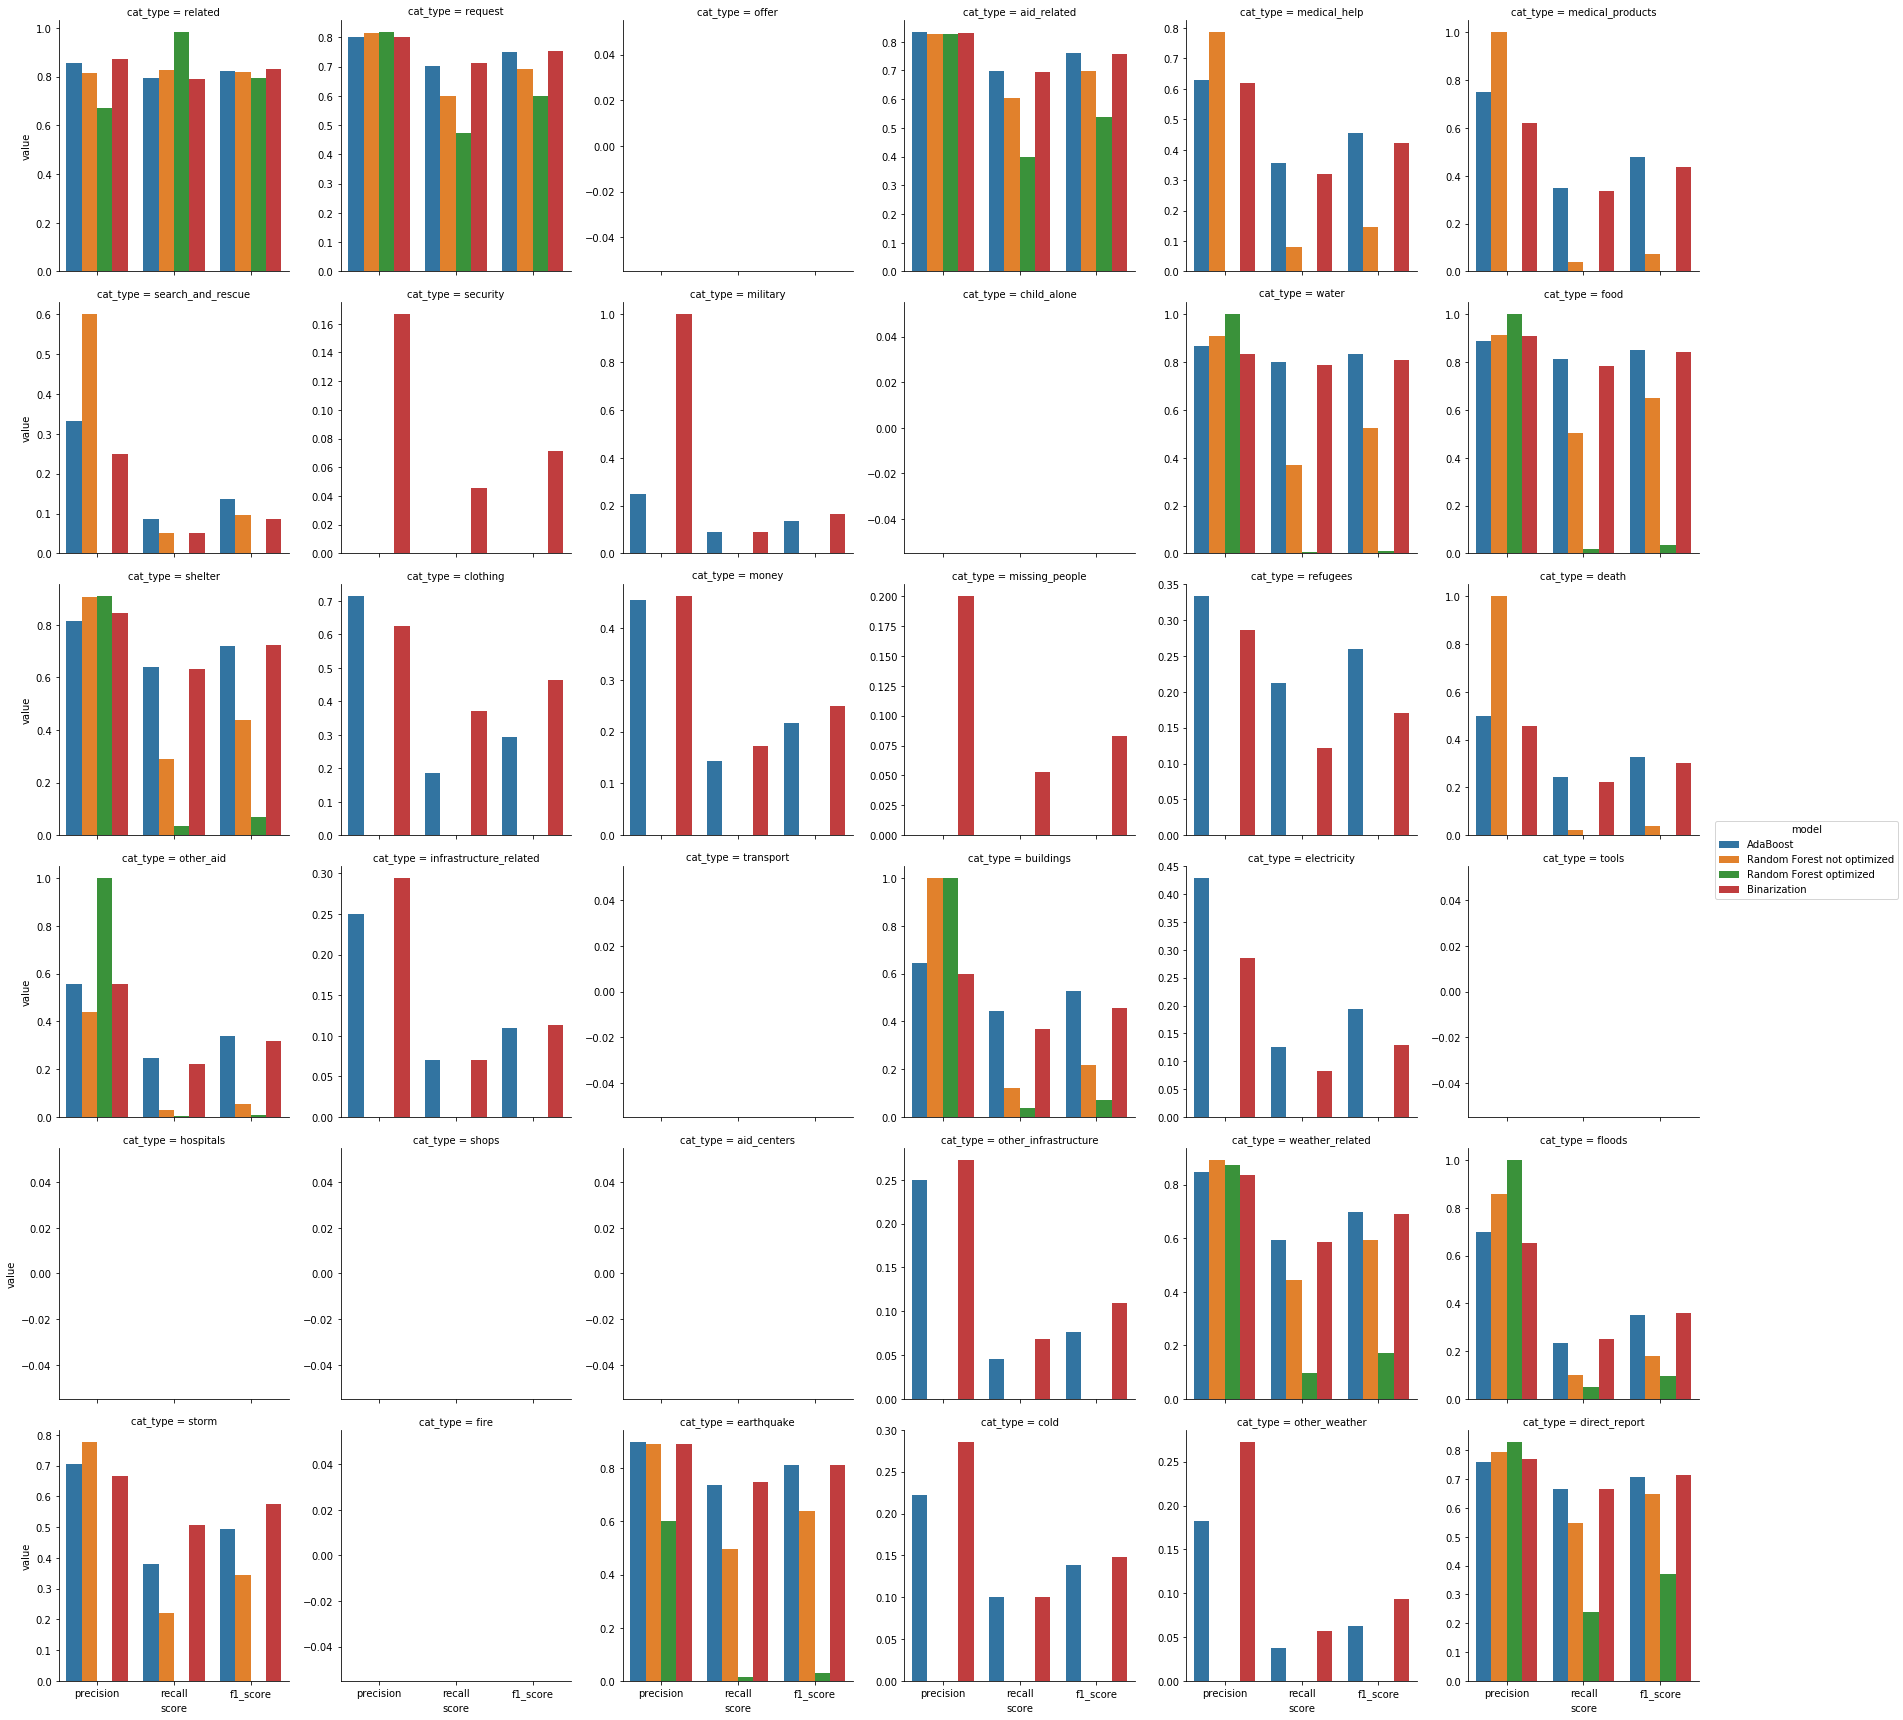

In [34]:
# Plotting the performance scores of all models and for all target labels 
sns.factorplot(x='score', y='value', hue='model', col='cat_type', data=df_melt, sharey=False, col_wrap=6, kind='bar');


In almost all of these cases, AdaBoost has better performance scores than the optimized and not optimized Random Forest Classifier. Thus, I will use AdaBoost as the predictor in my ML pipeline.

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.